/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_63255/2966791515.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, period='60d', progress=False, multi_level_index=False)


Trades:
       Ticker Entry Date  Exit Date  Entry Price  Exit Price   Pattern         P/L
IDFCFIRSTB.NS 2025-05-27 2025-06-02    66.382721    67.74826 ENGULFING 1954.202319
IDFCFIRSTB.NS 2025-07-21 2025-07-22    73.000000    74.00000 ENGULFING 1292.467500

Performance Metrics:
Total Return: 0.06
Win Rate: 100.00%
Number of Trades: 2.00
Max Drawdown: -1.90%


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_63255/2966791515.py:146: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  equity_all = pd.concat(equity_curves, axis=1).fillna(method='ffill').sum(axis=1)


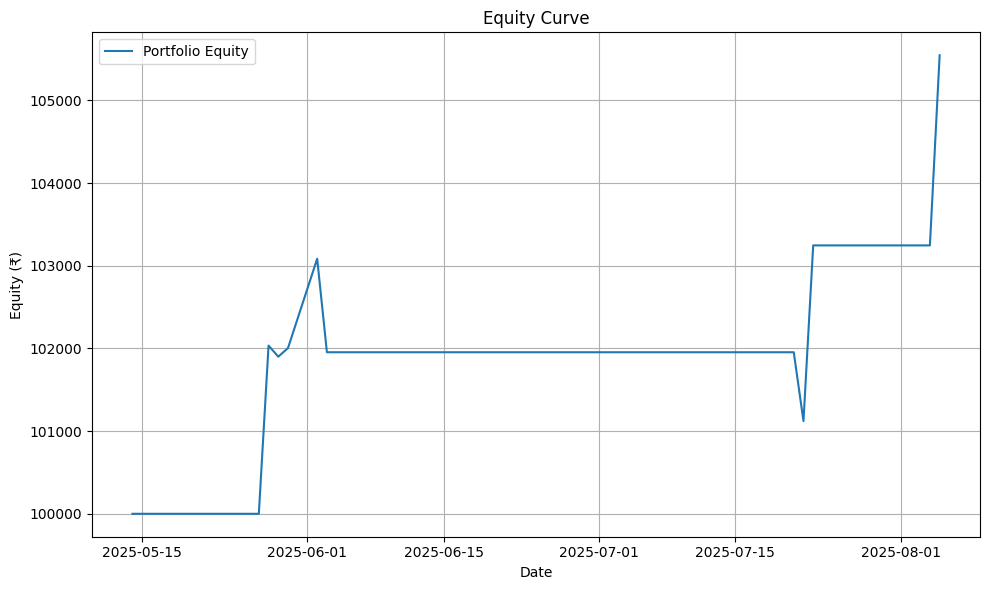

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import talib
import matplotlib.pyplot as plt
from datetime import timedelta

def download_data(tickers, start="2020-01-01", end=None):
    """
    Download daily OHLCV data for each ticker using yfinance.
    Returns a dict of DataFrames.
    """
    data = {}
    for t in tickers:
        df = yf.download(t, period='60d', progress=False, multi_level_index=False)
        df.dropna(inplace=True)
        data[t] = df
    return data

def detect_patterns(df):
    """
    Add columns for each chosen TA-Lib candlestick pattern.
    Positive values → bullish signal; negative → bearish signal.
    """
    patterns = {
        'ENGULFING': talib.CDLENGULFING,
        'MORNING_STAR': talib.CDLMORNINGSTAR,
        'HAMMER': talib.CDLHAMMER,
        # add more patterns here if desired
    }
    out = pd.DataFrame(index=df.index)
    for name, func in patterns.items():
        out[name] = func(df['Open'], df['High'], df['Low'], df['Close'])
    return out

def backtest(df, patterns_df, hold_days=5, initial_capital=100000.0, transaction_cost=0.0005):
    """
    Simple long-only backtest:
    - Buy at next open when any pattern > 0 (bullish).
    - Sell at next open when any pattern < 0 (bearish) OR after hold_days.
    - Flat when no position.
    Returns list of trades and equity time series.
    """
    capital = initial_capital
    equity = []  # (date, equity)
    trades = []
    position = 0
    entry_price = None
    entry_date = None
    entry_pattern = None

    dates = df.index

    for i, today in enumerate(dates):
        price_open = df.loc[today, 'Open']
        # record equity at close
        market_value = position * df.loc[today, 'Close']
        equity.append((today, capital + market_value))

        # if in position, check for exit
        if position:
            age = (today - entry_date).days
            # bearish signal?
            if (patterns_df.loc[today] < 0).any() or age >= hold_days:
                exit_price = price_open
                # apply transaction cost
                proceeds = exit_price * position * (1 - transaction_cost)
                pnl = proceeds - (entry_price * position * (1 + transaction_cost))
                capital += proceeds
                trades.append({
                    'Ticker': ticker,
                    'Entry Date': entry_date,
                    'Exit Date': today,
                    'Entry Price': entry_price,
                    'Exit Price': exit_price,
                    'Pattern': entry_pattern,
                    'P/L': pnl
                })
                position = 0

        # if flat, check for entry
        else:
            # bullish signal?
            sigs = patterns_df.loc[today]
            bullish = sigs[sigs > 0]
            if not bullish.empty:
                # pick first pattern
                entry_pattern = bullish.index[0]
                entry_price = price_open
                cost = entry_price * (1 + transaction_cost)
                position = capital // cost  # integer shares
                if position > 0:
                    capital -= position * cost
                    entry_date = today

    # convert equity to DataFrame
    eq_df = pd.DataFrame(equity, columns=['Date', 'Equity']).set_index('Date')
    trades_df = pd.DataFrame(trades)
    return trades_df, eq_df

def performance_metrics(trades_df, equity_df):
    """
    Compute performance: total return, win rate, num trades, max drawdown.
    """
    total_return = equity_df['Equity'].iloc[-1] / equity_df['Equity'].iloc[0] - 1
    wins = trades_df['P/L'] > 0
    win_rate = wins.sum() / len(trades_df) if len(trades_df) else np.nan
    num_trades = len(trades_df)
    # max drawdown
    cum_equity = equity_df['Equity']
    running_max = cum_equity.cummax()
    drawdown = (cum_equity - running_max) / running_max
    max_dd = drawdown.min()
    return {
        'Total Return': total_return,
        'Win Rate': win_rate,
        'Number of Trades': num_trades,
        'Max Drawdown': max_dd
    }

if __name__ == "__main__":
    # User inputs
    tickers = ['IDFCFIRSTB.NS']
    start_date = "2021-01-01"
    end_date = None  # today
    hold_days = 5
    initial_capital = 100000.0
    transaction_cost = 0.0005  # 0.05%

    # 1. Download data
    data = download_data(tickers, start=start_date, end=end_date)

    # 2. Run backtest per ticker and aggregate results
    all_trades = []
    equity_curves = []
    for ticker, df in data.items():
        patterns = detect_patterns(df)
        trades_df, eq_df = backtest(df, patterns, hold_days, initial_capital, transaction_cost)
        trades_df['Ticker'] = ticker
        all_trades.append(trades_df)
        eq_df.rename(columns={'Equity': ticker}, inplace=True)
        equity_curves.append(eq_df)

    # Combine
    trades = pd.concat(all_trades, ignore_index=True)
    equity_all = pd.concat(equity_curves, axis=1).fillna(method='ffill').sum(axis=1)

    # 3. Performance
    perf = performance_metrics(trades, pd.DataFrame({'Equity': equity_all}))
    print("Trades:")
    print(trades.to_string(index=False))
    print("\nPerformance Metrics:")
    for k, v in perf.items():
        if 'Rate' in k or 'Drawdown' in k:
            print(f"{k}: {v:.2%}")
        else:
            print(f"{k}: {v:.2f}")

    # 4. Plot equity curve
    plt.figure(figsize=(10, 6))
    plt.plot(equity_all.index, equity_all.values, label='Portfolio Equity')
    plt.title('Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('Equity (₹)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
